## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/geno/geno_maccs_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_maccs_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train = df_train_all['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

In [5]:
X_train.shape, y_train.shape

((19931, 166), (19931,))

In [6]:
X_test.shape, y_test.shape

((4984, 166), (4984,))

## 3. Metrics 📏

In [7]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 4. Models ⚙️

## 4.1. Ridge Regression

Poor results.

In [8]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 100, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 0.34475227942541486
MSE: 0.2166348562682158
RMSE: 0.465440497022139
R2 Square 0.0625420395369437 

Base model:
MAE: 0.3447466698081167
MSE: 0.21663670355577122
RMSE: 0.4654424814687323
R2 Square 0.06253404565057696 

Train set:
Tuned model:
MAE: 0.34914919074627826
MSE: 0.22340685145950528
RMSE: 0.4726593397569811
R2 Square 0.07919248031679904 

Base model:
MAE: 0.34914289171478335
MSE: 0.2234036743850971
RMSE: 0.47265597889490096
R2 Square 0.0792055751435089 



In [9]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.46544,0.062542


## 4.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [18]:
# default: 'n_estimators': 100, 'max_depth': None

params = {
    'max_depth': [5, 10, 12, 13],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 13, 'n_estimators': 1000} 

Test set:
Tuned model:
MAE: 0.325904043420038
MSE: 0.19253487347819337
RMSE: 0.4387879595866247
R2 Square 0.16683144661904836 

Base model:
MAE: 0.32594535176411454
MSE: 0.19321526496951924
RMSE: 0.43956258367781853
R2 Square 0.16388714471508758 

Train set:
Tuned model:
MAE: 0.23602382770747757
MSE: 0.09791690045814733
RMSE: 0.31291676282702935
R2 Square 0.5964196368334013 

Base model:
MAE: 0.23567118892744798
MSE: 0.0978310868419785
RMSE: 0.3127796138529148
R2 Square 0.5967733315502072 



In [10]:
params = {'max_depth': 13, 'n_estimators': 1000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.325904043420038
MSE: 0.19253487347819337
RMSE: 0.4387879595866247
R2 Square 0.16683144661904836 

Train set:
MAE: 0.23602382770747757
MSE: 0.09791690045814733
RMSE: 0.31291676282702935
R2 Square 0.5964196368334013 



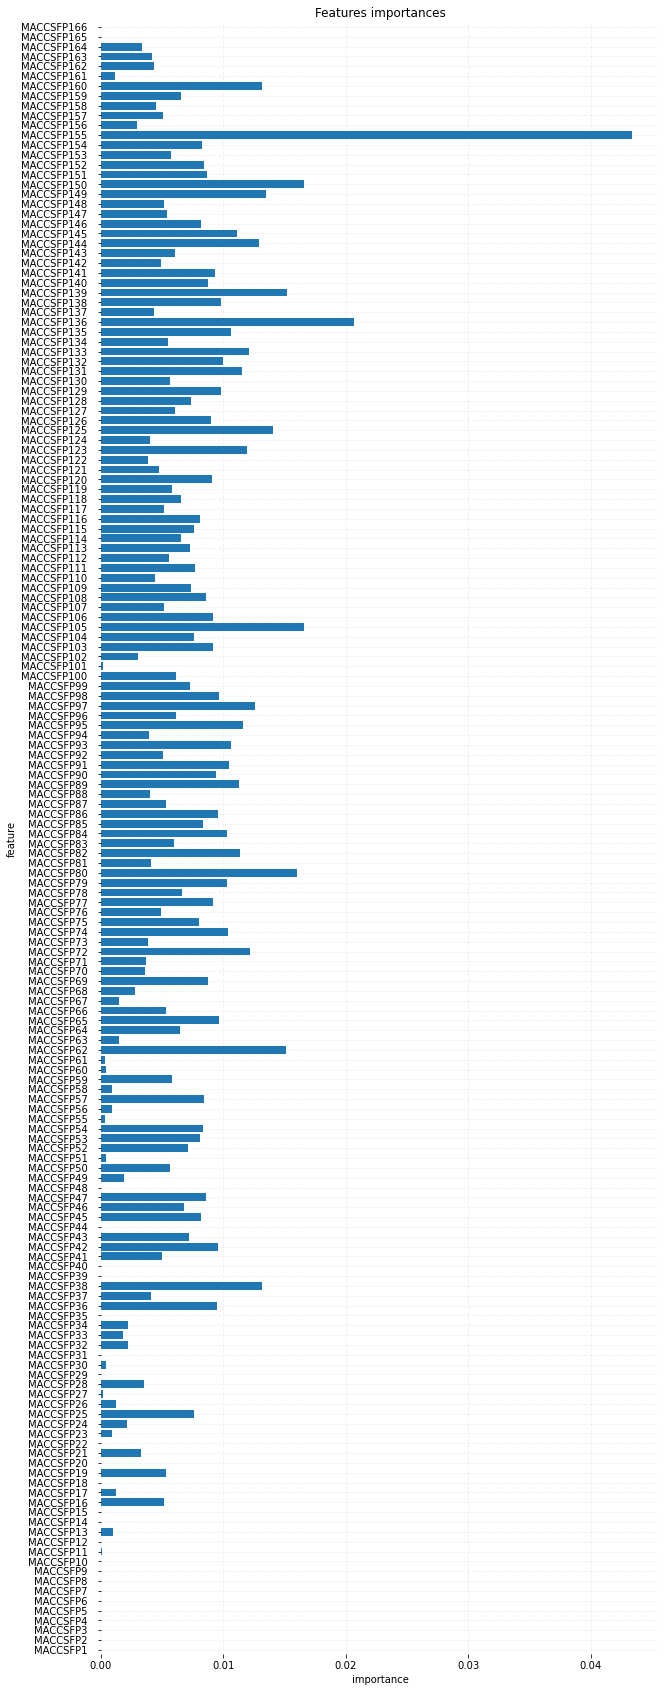

In [11]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [12]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831


## 4.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [17]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [4, 8, 10, 15],
    'n_estimators': [500, 1000, 2000, 3000, 4000],
    'min_child_weight': [80, 90, 150, 180],
    'colsample_bytree': [0.3],
    'subsample': [0.9]   
}

params = {'colsample_bytree': [0.3], 'eta': [0.01], 'gamma': [0.1], 'lambda': [0.6], 'max_depth': [15], 
          'min_child_weight': [90], 'n_estimators': [2000], 'subsample': [0.9]} 

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.3128127407916203
MSE: 0.18434385333340375
RMSE: 0.42935283082029835
R2 Square 0.2022769754287761 

Base model:
MAE: 0.32653809227859193
MSE: 0.20127314105750757
RMSE: 0.44863475239609735
R2 Square 0.12901777875415898 

Train set:
Tuned model:
MAE: 0.2516177920897006
MSE: 0.12132888963475591
RMSE: 0.3483229674235621
R2 Square 0.4999233318019036 

Base model:
MAE: 0.286451045621867
MSE: 0.15338427109738345
RMSE: 0.39164304040463105
R2 Square 0.3678018856409244 



In [8]:
params = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.3128127407916203
MSE: 0.18434385333340375
RMSE: 0.42935283082029835
R2 Square 0.2022769754287761 

Train set:
MAE: 0.2516177920897006
MSE: 0.12132888963475591
RMSE: 0.3483229674235621
R2 Square 0.4999233318019036 



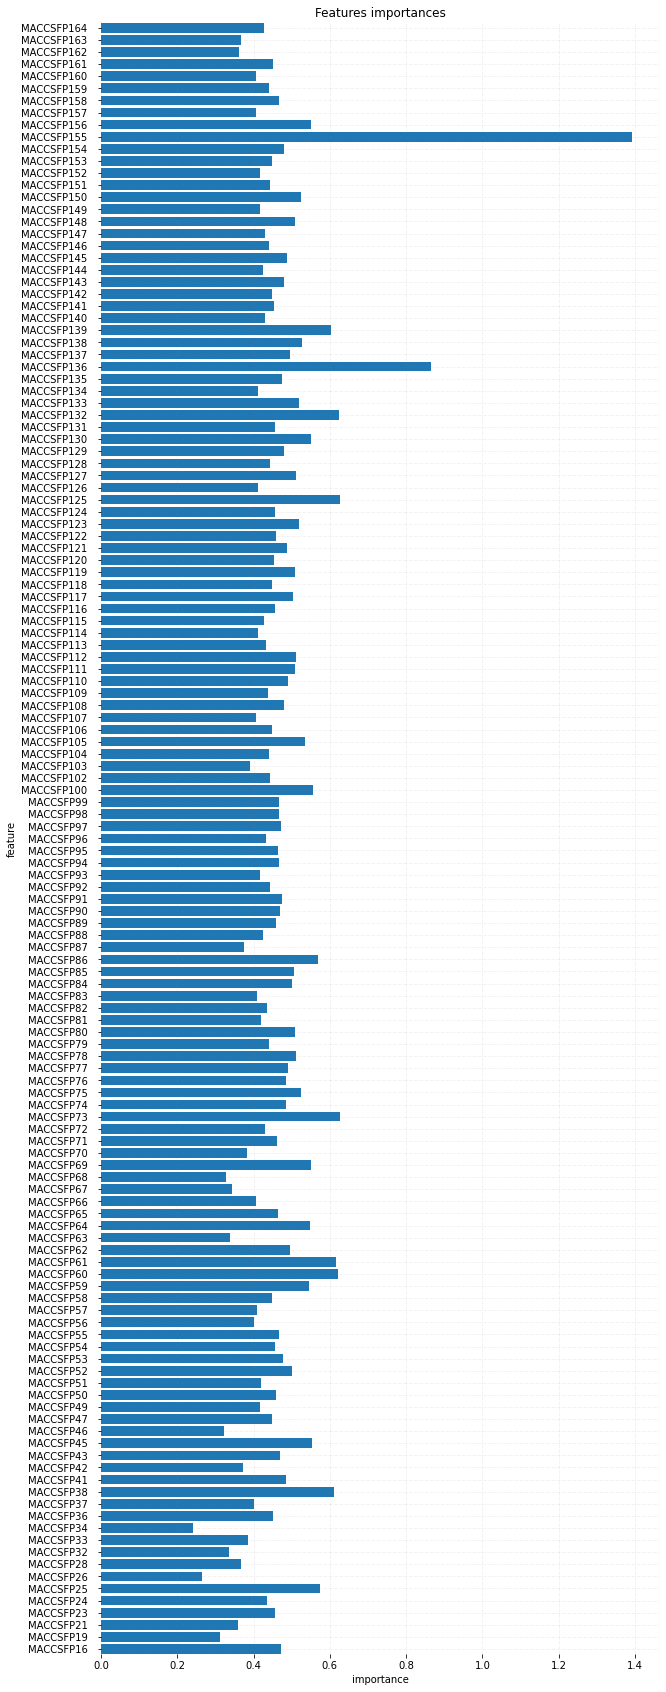

In [19]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [20]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277


## 4.4. LightGBM

Better results - third model.

In [33]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 4000, 5000],
    'min_child_samples': [15, 20, 40, 50],
    'reg_alpha': [1.7, 2.7, 2.9],
    'reg_lambda': [0.04, 0.06],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 15, 'n_estimators': 5000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 0.31616429522952605
MSE: 0.1876809419747595
RMSE: 0.43322158530567184
R2 Square 0.18783617690955468 

Base model:
MAE: 0.32588617499170147
MSE: 0.19604732355736115
RMSE: 0.4427723157079281
R2 Square 0.15163179526022852 

Train set:
Tuned model:
MAE: 0.274217026049462
MSE: 0.1414394053738748
RMSE: 0.3760843062052375
R2 Square 0.4170345842262968 

Base model:
MAE: 0.30778269492990595
MSE: 0.1732973886747452
RMSE: 0.416290029516376
R2 Square 0.28572674655820907 



In [34]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 15, 'n_estimators': 5000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.3164625921850623
MSE: 0.18793443302610222
RMSE: 0.43351405170548074
R2 Square 0.18673922876334703 

Train set:
MAE: 0.27546389387249426
MSE: 0.14264515548436763
RMSE: 0.3776839359628201
R2 Square 0.41206488987114454 



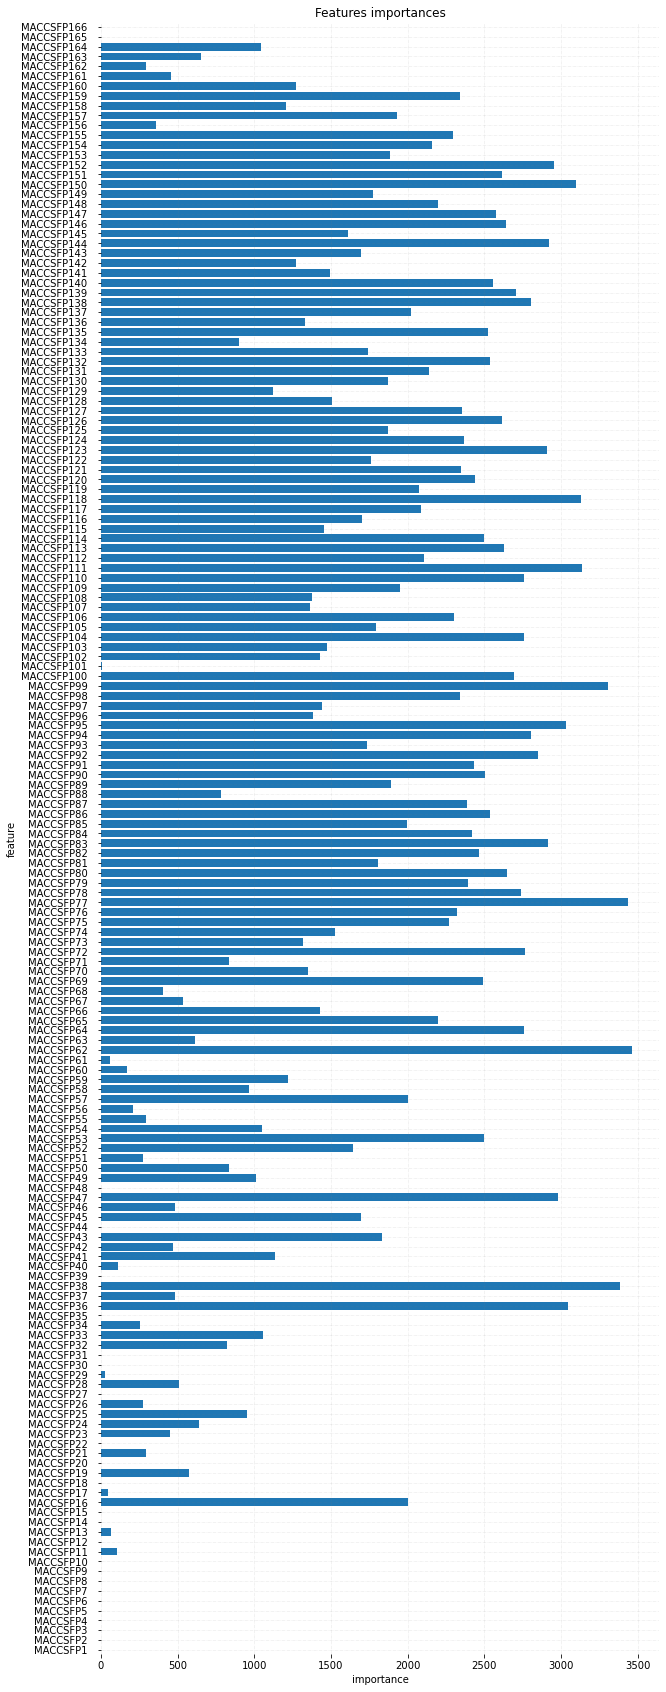

In [35]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [36]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277
3,LightGBM,0.316463,0.187934,0.433514,0.186739


## 4.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [55]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0

params = {
    'learning_rate': [0.005, 0.1, 0.25],
    'max_depth': [5, 15, 25, 30],
    'l2_regularization': [0, 0.1, 0.2],
    'min_samples_leaf':[8, 10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0, 'learning_rate': 0.25, 'max_depth': 25, 'min_samples_leaf': 20} 

Test set:
Tuned model:
MAE: 0.3235773412077874
MSE: 0.19471355491817957
RMSE: 0.4412635889331677
R2 Square 0.1574034981604704 

Base model:
MAE: 0.32667347565273575
MSE: 0.19690109895158375
RMSE: 0.4437353929444706
R2 Square 0.14793719803082184 

Train set:
Tuned model:
MAE: 0.2779574121121463
MSE: 0.14459698927452747
RMSE: 0.38025910807570074
R2 Square 0.40402009079981116 

Base model:
MAE: 0.30925337922226315
MSE: 0.17554816183316857
RMSE: 0.41898467971176295
R2 Square 0.2764498204664727 



In [56]:
params = {'l2_regularization': 0, 'learning_rate': 0.25, 'max_depth': 25, 'min_samples_leaf': 20} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.3235773412077874
MSE: 0.19471355491817957
RMSE: 0.4412635889331677
R2 Square 0.1574034981604704 

Train set:
MAE: 0.2779574121121463
MSE: 0.14459698927452747
RMSE: 0.38025910807570074
R2 Square 0.40402009079981116 



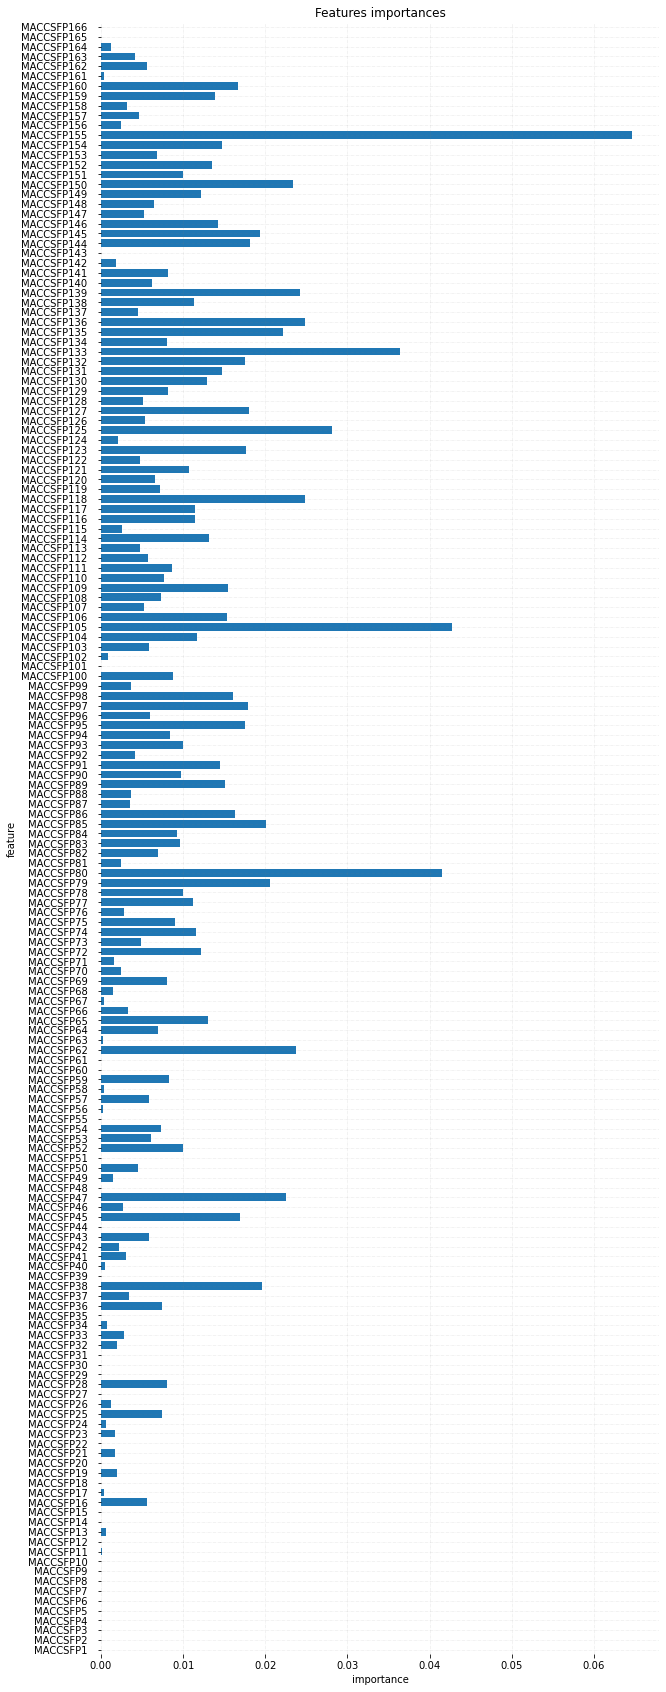

In [57]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [58]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277
3,LightGBM,0.316463,0.187934,0.433514,0.186739
4,HistGradient Boosting Regressor,0.323577,0.194714,0.441264,0.157403


## 4.6. Support Vector Regression

Better results - fifth model.

In [63]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0],
    'epsilon': [0.05, 0.1, 0.2],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.31786164363645775
MSE: 0.19344521745559703
RMSE: 0.43982407557522024
R2 Square 0.16289205651776162 

Base model:
MAE: 0.30638374792043344
MSE: 0.19963676099710373
RMSE: 0.44680729738568925
R2 Square 0.13609899153955363 

Train set:
Tuned model:
MAE: 0.2373553976073493
MSE: 0.11809798853346509
RMSE: 0.3436538789734012
R2 Square 0.5132400139447545 

Base model:
MAE: 0.24900841219015543
MSE: 0.15932513007144927
RMSE: 0.39915552115866976
R2 Square 0.3433156732398298 



In [64]:
params = {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.31786164363645775
MSE: 0.19344521745559703
RMSE: 0.43982407557522024
R2 Square 0.16289205651776162 

Train set:
MAE: 0.2373553976073493
MSE: 0.11809798853346509
RMSE: 0.3436538789734012
R2 Square 0.5132400139447545 



In [ ]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [66]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277
3,LightGBM,0.316463,0.187934,0.433514,0.186739
4,HistGradient Boosting Regressor,0.323577,0.194714,0.441264,0.157403
5,Support Vector Regression,0.317862,0.193445,0.439824,0.162892


### Save models

In [9]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''
pickle.dump(xgbr_best, open('../../models/geno_maccs_xgb.pkl', 'wb'))

## 4.7. Stacking models

### Averaging base models

In [67]:
def average_predictions(X):
    return ((0.15 * rf_best.predict(X)) + \
            (0.3 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.15 * hist_best.predict(X)) + \
            (0.15 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.31400205732386643
MSE: 0.18467448921611318
RMSE: 0.42973769815564605
R2 Square 0.20084619348721766 

Train set:
MAE: 0.2536026119017874
MSE: 0.12171537833449604
RMSE: 0.3488773112922307
R2 Square 0.49833035603294973 



In [68]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277
3,LightGBM,0.316463,0.187934,0.433514,0.186739
4,HistGradient Boosting Regressor,0.323577,0.194714,0.441264,0.157403
5,Support Vector Regression,0.317862,0.193445,0.439824,0.162892
6,Averaging base models,0.314002,0.184674,0.429738,0.200846


### Averaging base models with Meta-model

In [69]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [70]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.137143,5.232141,5.171357,5.210088,5.202151
1,5.177629,5.179510,5.180602,5.262557,5.079618
2,5.252763,5.369344,5.387455,5.370118,5.292124
3,4.843536,4.776423,4.777779,4.751120,4.877465
4,4.795548,4.685681,4.746408,4.812374,4.686664
...,...,...,...,...,...
19926,4.740830,4.789058,4.709093,4.657255,4.750112
19927,4.993835,4.969943,4.980089,5.117326,5.040286
19928,5.057518,5.114032,5.043665,4.926650,5.185912
19929,5.094933,5.223867,5.083252,5.145334,5.386161


In [77]:
params = {'alpha': 0.9} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.3357661689176474
MSE: 0.21617274910823364
RMSE: 0.46494381285079345
R2 Square 0.0645417456007541 

Train set:
MAE: 0.16386063875094845
MSE: 0.053080072248126525
RMSE: 0.23039112883990678
R2 Square 0.7812218857564364 



In [78]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277
3,LightGBM,0.316463,0.187934,0.433514,0.186739
4,HistGradient Boosting Regressor,0.323577,0.194714,0.441264,0.157403
5,Support Vector Regression,0.317862,0.193445,0.439824,0.162892
6,Averaging base models,0.314002,0.184674,0.429738,0.200846
7,Base models + Meta-model,0.335766,0.216173,0.464944,0.064542


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [79]:
params_rf = {'max_depth': 13, 'n_estimators': 1000} 

params_xgb = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 15, 'n_estimators': 5000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

params_hist = {'l2_regularization': 0, 'learning_rate': 0.25, 'max_depth': 25, 'min_samples_leaf': 20} 

params_svr =  {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

In [81]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    
        
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.1970115451117062
Model1 R2: 0.15698002000080613
Model2 MSE: 0.1891178681657066
Model2 R2: 0.19075736729973503
Model3 MSE: 0.19322608798731705
Model3 R2: 0.17317813665169024
Model4 MSE: 0.20225396624474506
Model4 R2: 0.13454749831170454
Model5 MSE: 0.19790551528708755
Model5 R2: 0.15315468723189385
Average MSE = 0.19590299655931248
Average R2 = 0.16172354189916596
-------------- fold 2 --------------
Model1 MSE: 0.19763884328044953
Model1 R2: 0.17451468388865743
Model2 MSE: 0.19346897856793527
Model2 R2: 0.19193110888496723
Model3 MSE: 0.1963869433457824
Model3 R2: 0.17974353969531698
Model4 MSE: 0.2104484445091259
Model4 R2: 0.12101235841456304
Model5 MSE: 0.19932316701844074
Model5 R2: 0.16747970791828837
Average MSE = 0.1994532753443468
Average R2 = 0.1669362797603586
-------------- fold 3 --------------
Model1 MSE: 0.19087429021107669
Model1 R2: 0.17958779133887337
Model2 MSE: 0.18128752728603906
Model2 R2: 0.22079343164036802
Model

In [82]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [83]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [84]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.086609,5.233391,5.135243,4.957469,5.231558
1,5.228861,5.233840,5.171640,5.157689,5.243735
2,5.254910,5.455286,5.454106,5.273269,5.323580
3,4.907681,4.868374,4.873036,4.941763,4.806856
4,4.823198,4.784139,4.760165,4.801673,4.792383
...,...,...,...,...,...
19926,4.857179,4.785426,4.789820,4.863418,4.762689
19927,4.996014,4.989635,4.989371,5.180308,5.033261
19928,4.952001,5.012042,5.013337,5.062160,5.186382
19929,4.940710,5.063971,4.998796,4.893548,5.225388


In [85]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.953330,5.902756,5.872084,5.482413,5.894641
1,5.167238,5.018903,5.039914,4.910354,5.117972
2,5.031325,5.093065,5.018810,5.015023,5.012096
3,5.020623,4.833297,4.822396,4.852875,4.846120
4,5.157018,4.736269,4.726898,4.879895,4.630707
...,...,...,...,...,...
4979,5.029768,5.072905,5.079459,5.024443,4.965587
4980,5.014341,5.061897,5.046630,5.076301,5.035489
4981,5.041896,5.350908,5.294776,5.197052,5.253573
4982,4.851087,4.682764,4.664188,4.759359,4.635685


In [89]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.31240270142189036
MSE: 0.18415926277759617
RMSE: 0.42913781326934614
R2 Square 0.20307576602484656 

Train set:
MAE: 0.31948840548366186
MSE: 0.19444687946116682
RMSE: 0.4409613128848911
R2 Square 0.19855569506009707 



In [90]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.344752,0.216635,0.465440,0.062542
1,Random Forest Regressor,0.325904,0.192535,0.438788,0.166831
2,XGBoost,0.312813,0.184344,0.429353,0.202277
3,LightGBM,0.316463,0.187934,0.433514,0.186739
4,HistGradient Boosting Regressor,0.323577,0.194714,0.441264,0.157403
5,Support Vector Regression,0.317862,0.193445,0.439824,0.162892
6,Averaging base models,0.314002,0.184674,0.429738,0.200846
7,Base models + Meta-model,0.335766,0.216173,0.464944,0.064542
8,Base models + Meta-model + cv,0.312403,0.184159,0.429138,0.203076
